# Software and Systems Performance - Project 
Coverage Analysis of YCSB benchmark tool for Mongodb Database

In [16]:
import matplotlib.pyplot as plt
import json
import os

In [21]:
with open('json_outputs_with_branch/mongod_main.gcov.json' ,'r') as f:
    data=json.load(f)
    data=data['files']
    print(data[0].keys())

dict_keys(['lines', 'functions', 'file'])


In [3]:
def gen_demangled_index(data):
    demangled_index={}
    for function in data['functions']:
        demangled_index[function['name']]=function['demangled_name']
    return demangled_index
demangled_index=(gen_demangled_index(data[0]))


In [4]:
data[0]['lines'][0]

{'branches': [],
 'count': 6,
 'line_number': 265,
 'unexecuted_block': False,
 'function_name': '_ZN5mongo12_GLOBAL__N_110logStartupEPNS_16OperationContextE'}

#### data[i]['lines'] has the data of every line of file i. 

In [22]:

h_files=0
cpp_files=0
for file in data:
    if file['file'].endswith('.h') or file['file'].endswith('.hpp'):
        h_files+=1
    else:
        cpp_files+=1
        print(file['file'])

print(h_files,cpp_files)

src/mongo/db/mongod_main.cpp
279 1


The number of cpp files in a gcov file is just 1 while the remaining files in the data are all header files. We will find line coverage only for the cpp files

In [34]:
# Get the cpp file data and ignore the .h file data
def get_cpp_file(data):
    CPP_FILE=None
    for file in data:
        if file['file'].endswith('.h') or file['file'].endswith('.hpp'):
            continue
        else:
            # print(file['file'])
            CPP_FILE  = file
            return CPP_FILE
CPP_FILE = get_cpp_file(data)

In [24]:
def get_line_coverage(file):
    cnt=0
    for line in file.get('lines',[]):
        if(line['count']>0):
            cnt+=1
    return (cnt,len(file['lines']))
get_line_coverage(CPP_FILE)

(455, 728)

In [26]:
def get_function_coverage(file):
    cnt=0
    for function in file.get('functions',[]):
        if(function['execution_count']>0):
            cnt+=1
    return (cnt,len(file['functions']))
get_function_coverage(CPP_FILE)


(19, 31)

#### To find the top 3 lengthiest unexecuted functions in the .cpp file


In [28]:
def get_longest_unused_functions(file):
    unex_func=[]
    for function in file.get('functions',[]):
        if(function['execution_count']==0):
            unex_func.append((function['demangled_name'],function['end_line']-function['start_line']+1))
    unex_func=sorted(unex_func,key=lambda x:-x[1])
    return unex_func[:3]
get_longest_unused_functions(CPP_FILE)

[('mongo::(anonymous namespace)::shutdownProcessByDBPathPidFile(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&)',
  55),
 ('mongo::(anonymous namespace)::makeReplicaSetNodeExecutor(mongo::ServiceContext*)',
  15),
 ('mongo::(anonymous namespace)::initializeCommandHooks(mongo::ServiceContext*)::MongodCommandInvocationHooks::onAfterAsyncRun(std::shared_ptr<mongo::RequestExecutionContext>, mongo::CommandInvocation*)',
  5)]

### Branch Coverage 

#### Sample Branch JSON
It has 3 fields:
* fallthrough: 
    * True - Control moves to next line after executing the branch
    * False - Control jumps to another line (Branch taken)
* Count: Number of times the branch condition was evaluated
* Throw: If branch throws an exception 

In [8]:
Flag = False
for line in CPP_FILE['lines']:
    for branch in line['branches']:
        Flag = True
        print(branch)
        break
    if Flag:
        break

{'fallthrough': True, 'count': 6, 'throw': False}


In [29]:
# A branch must have nonzero counts for both fallthrough=True and fallthrough=False to have 100% coverage
def get_branch_coverage(file):
    NUM_BRANCHES = 0
    BRANCHES_TAKEN = 0
    for line in file.get('lines',[]):
        if not line['branches']:
            continue
        
        NUM_BRANCHES += 2
        branches_taken = {
            "fallthrough": False,
            "jump": False
        }
        for branch in line['branches']:
            if branch['fallthrough'] and branch['count'] != 0:
                branches_taken['fallthrough'] = True
            
            elif (not branch['fallthrough']) and branch['count'] != 0:
                branches_taken['jump'] = True

        if branches_taken['fallthrough']:
            BRANCHES_TAKEN += 1
        if branches_taken['jump']:
            BRANCHES_TAKEN += 1
    
    return BRANCHES_TAKEN, NUM_BRANCHES
        

## Calculating Total Percentage Coverage
  TPC = (BT + BF + SC + MC)/(2*B + S + M) * 100%

where

* BT - branches that evaluated to "true" at least once
* BF - branches that evaluated to "false" at least once
* SC - statements covered
* MC - methods entered

* B - total number of branches
* S - total number of statements
* M - total number of methods

In [56]:
def get_TPC(file):
    BT_BF,B = get_branch_coverage(file)
    #BT+BF
    SC ,S = get_line_coverage (file)
    MC ,M = get_function_coverage(file)
    return(((BT_BF + SC + MC)/(2*B + S + M))*100)



### Calculating the code coverage for all the cpp files

In [86]:
overall_stats={}
unexecuted_files=[]
for file in os.listdir('json_outputs_with_branch'):
    filename=os.path.join('json_outputs_with_branch',file)
    with open(filename,'r') as f:
        data=json.load(f)
        data=data['files']
        CPP_FILE = get_cpp_file(data)
        if CPP_FILE is not None:

            sc,s = get_line_coverage(CPP_FILE)
            if(s==0):
                print(CPP_FILE)
                continue
            mc,m = get_function_coverage(CPP_FILE)
            bt_bf,b = get_branch_coverage(CPP_FILE)
            tpc=get_TPC(CPP_FILE)
            overall_stats[CPP_FILE['file']]={
            'sc':sc,
            'mc':mc,
            'bt_bf':bt_bf,
            'b':b,
            's':s,
            'm':m,
            'tpc':tpc
        }
        else:
            unexecuted_files.append(file.strip('.gcov.json'))





{'lines': [], 'functions': [], 'file': 'src/mongo/db/server_parameter_with_storage.cpp'}


In [63]:
(overall_stats)

{'src/mongo/db/cancelable_operation_context.cpp': {'sc': 0,
  'mc': 0,
  'bt_bf': 0,
  'b': 24,
  's': 22,
  'm': 4,
  'tpc': 0.0},
 'src/mongo/db/multi_key_path_tracker.cpp': {'sc': 4,
  'mc': 2,
  'bt_bf': 0,
  'b': 38,
  's': 55,
  'm': 12,
  'tpc': 4.195804195804196},
 'src/mongo/db/database_name.cpp': {'sc': 0,
  'mc': 0,
  'bt_bf': 0,
  'b': 0,
  's': 2,
  'm': 1,
  'tpc': 0.0},
 'src/mongo/db/server_options_init.cpp': {'sc': 3,
  'mc': 1,
  'bt_bf': 1,
  'b': 2,
  's': 3,
  'm': 1,
  'tpc': 62.5},
 'src/mongo/db/ttl.cpp': {'sc': 173,
  'mc': 13,
  'bt_bf': 124,
  'b': 410,
  's': 349,
  'm': 29,
  'tpc': 25.87646076794658},
 'src/mongo/db/change_collection_expired_documents_remover.cpp': {'sc': 3,
  'mc': 1,
  'bt_bf': 1,
  'b': 84,
  's': 83,
  'm': 8,
  'tpc': 1.9305019305019304},
 'src/mongo/db/traffic_recorder.cpp': {'sc': 18,
  'mc': 7,
  'bt_bf': 8,
  'b': 182,
  's': 169,
  'm': 26,
  'tpc': 5.903398926654741},
 'src/mongo/db/index_names.cpp': {'sc': 14,
  'mc': 3,
  'bt_

In [72]:

statement_coverage = [(x['sc']/x['s'])*100 for x in overall_stats.values()]
method_coverage = [(x['mc']/x['m'])*100 for x in overall_stats.values()]
branch_coverage = [(x['bt_bf']/x['b'])*100 for x in overall_stats.values() if x['b'] != 0]
tpc_coverage = [x['tpc'] for x in overall_stats.values()]


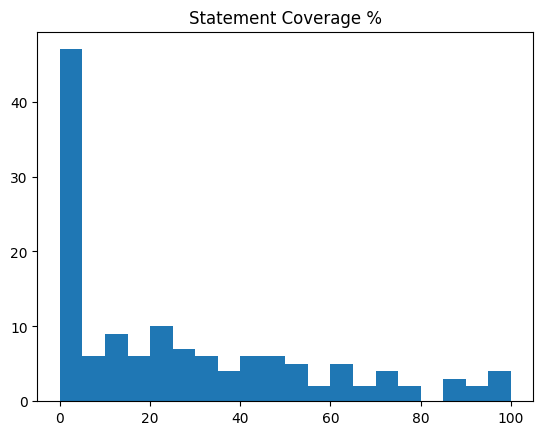

In [77]:
plt.hist(statement_coverage,bins=20)
plt.title("Statement Coverage %")
plt.show()

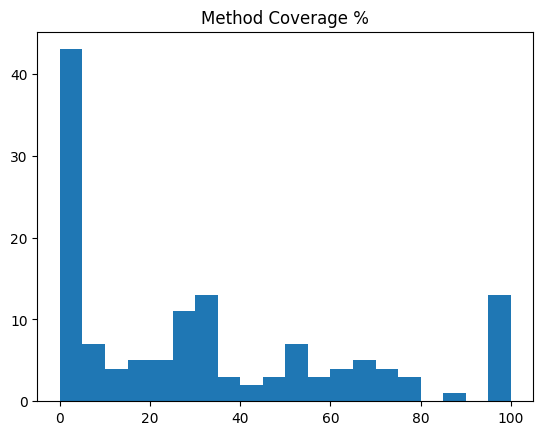

In [78]:
plt.hist(method_coverage,bins=20)
plt.title("Method Coverage %")
plt.show()

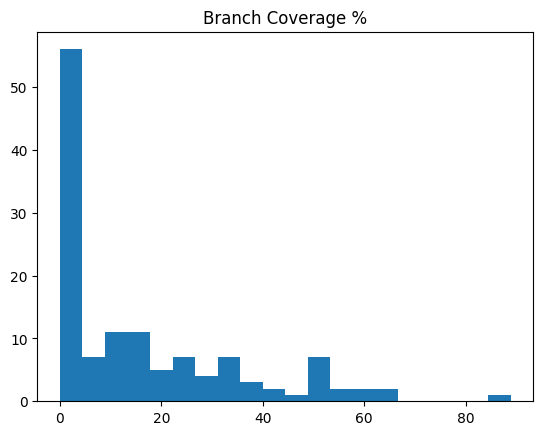

In [79]:
plt.hist(branch_coverage,bins=20)
plt.title("Branch Coverage %")
plt.show()

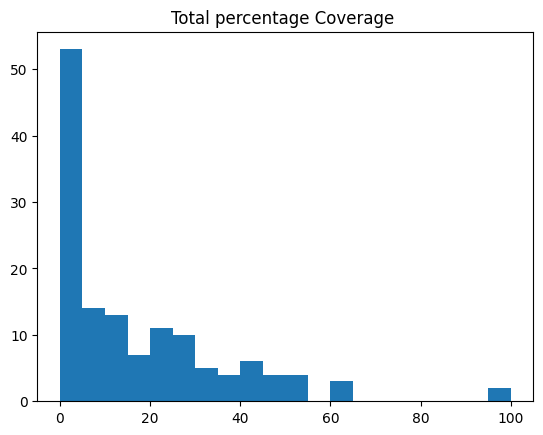

In [80]:
plt.hist(tpc_coverage,bins=20)
plt.title("Total percentage Coverage ")
plt.show()

In [81]:
no_statement_files=[]
no_method_files=[]
no_branch_files=[]
for file,data in overall_stats.items():
    if(data['sc']==0):
        no_statement_files.append(file)
    if(data['bt_bf']==0):
        no_branch_files.append(file)
    if(data['mc']==0):
        no_method_files.append(file)




In [83]:
no_statement_files

['src/mongo/db/cancelable_operation_context.cpp',
 'src/mongo/db/database_name.cpp',
 'src/mongo/db/index_build_entry_helpers.cpp',
 'src/mongo/db/change_stream_change_collection_manager.cpp',
 'src/mongo/db/change_stream_pre_images_collection_manager.cpp',
 'src/mongo/db/shard_id.cpp',
 'src/mongo/db/keys_collection_cache.cpp',
 'src/mongo/db/fle_crud.cpp',
 'src/mongo/db/key_generator.cpp',
 'src/mongo/db/coll_mod_reply_validation.cpp',
 'src/mongo/db/change_streams_cluster_parameter.cpp',
 'src/mongo/db/global_index.cpp',
 'src/mongo/db/time_proof_service.cpp',
 'src/mongo/db/operation_context_group.cpp',
 'src/mongo/db/range_arithmetic.cpp',
 'src/mongo/db/cloner.cpp',
 'src/mongo/db/traffic_recorder_validators.cpp',
 'src/mongo/db/cluster_transaction_api.cpp',
 'src/mongo/db/operation_key_manager.cpp',
 'src/mongo/db/introspect.cpp',
 'src/mongo/db/rs_local_client.cpp',
 'src/mongo/db/rebuild_indexes.cpp',
 'src/mongo/db/keys_collection_client_direct.cpp',
 'src/mongo/db/service_l

### Inferences and Conclusions 
 ##### Why do some files have 0 statement coverage
  * shard_id.cpp - There is no sharding in database?
  * src/mongo/db/cancelable_operation_context.cpp - YCSB workloads never interrupted/cancelled an operation on the database
  * src/mongo/db/database_name.cpp, multitenancy.cpp- We used the default installation and had no multitenancy or name for it
  * src/mongo/db/index_build_entry_helpers.cpp, global_index - This file provides helper function to index the database. YCSB workload by default do not index the data.
  * key_collection.cpp - YCSB provies the keys and does not test the case where mongodb generates the keys


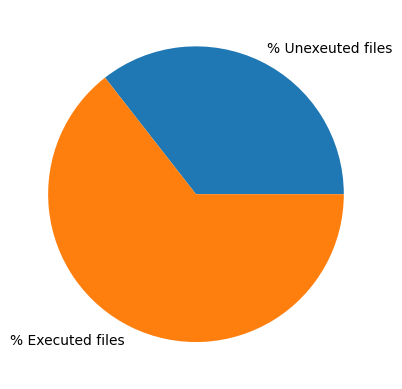

In [91]:
unex_files=len(unexecuted_files)
exec_files=len(overall_stats)
total=unex_files+exec_files
plt.pie([unex_files/total,exec_files/total],labels=['% Unexeuted files','% Executed files'])
plt.show()

## Overall line coverage
<img src="total_lines.png"/>

In [16]:
get_branch_coverage(CPP_FILE)

(368, 1018)

In [33]:
def get_condition_coverage(file):
    NUM_COND = 0
    COND_EVALUATED = 0
    for line in file['lines']:
        if not line['branches']:
            continue

        conditions = []
        i = 0
        for branch in line['branches']:
            if i%2==0:
                conditions.append([branch])
            else:
                conditions[-1].append(branch)
            i += 1

        for condition in conditions:
            NUM_COND += 1
            try:
                if condition[0]["count"] or condition[1]["count"]:
                    COND_EVALUATED += 1
            except:
                print(len(line['branches']), condition)
    return COND_EVALUATED, NUM_COND

In [34]:
get_condition_coverage(CPP_FILE)

7 [{'fallthrough': False, 'count': 0, 'throw': False}]
7 [{'fallthrough': False, 'count': 0, 'throw': False}]
11 [{'fallthrough': False, 'count': 0, 'throw': False}]


(513, 914)